In [1]:
import os

In [2]:
from CourseEA.CPreprocess import File
file = File("dataset/result/")

In [3]:
files_dir_list = file.get_files_dir_list()
files_dir_list

['dataset/result/comment_data.csv']

In [4]:
files_name_list = file.get_files_name_list()
files_name_list

['comment_data.csv']

In [5]:
from CourseEA.CPreprocess import Data
dt = Data(files_dir_list)

In [6]:
dataset = dt.get_dataset()

In [7]:
dt.get_dataset_shape()

(2571, 4)

积极评论数：2429；消极评论数：142


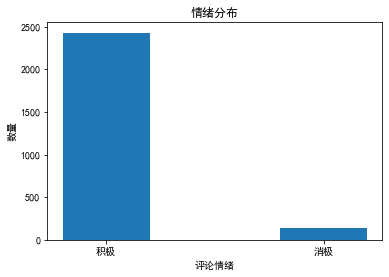

In [8]:
dt.get_dataset_distribution()

In [9]:
from CourseEA.DataPreProcess import DataProcess

In [ ]:
dataProcess = DataProcess(dataset)

预计需要几分钟的加载时间。。。


In [ ]:
cn_model = dataProcess.get_cn_model()


In [ ]:
train_texts_origin, train_score, train_target = dataProcess.process()

In [ ]:
len(train_texts_origin)

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import re
import jieba # 结巴分词

In [ ]:
# 分词后
train_tokens = []
for i, text in enumerate(train_texts_origin):
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    text = re.sub('[^\w\u4e00-\u9fff]+', '', text)
    text = re.sub('[0-9]','', text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [i for i in cut]
    # 去除例如6666这样子的评论
    if len(cut_list) == 1:
        del train_score[i]
        del train_target[i]
    elif len(cut_list) == 0:
        del train_score[i]
        del train_target[i]
    else:
        for i, word in enumerate(cut_list):
            try:
                # 将词转换为索引index
                cut_list[i] = cn_model.vocab[word].index
            except KeyError:
                # 如果词不在字典中，则输出0
                cut_list[i] = 0
        train_tokens.append(cut_list)

In [ ]:
len(train_tokens)

In [ ]:
len(train_score)

In [ ]:
len(train_target)

In [ ]:
cn_model.index2word[train_tokens[0][0]]

In [ ]:
import numpy as np
# 获得所有tokens的长度
num_tokens = [len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)

In [ ]:
# 平均tokens的长度
np.mean(num_tokens)

In [ ]:
# 最长的评价tokens的长度
np.max(num_tokens)

In [ ]:
import matplotlib.pyplot as plt
np.log(num_tokens)
plt.hist(np.log(num_tokens), bins = 100)
plt.xlim((0,10))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [ ]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖99%左右的样本
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

In [ ]:
# 取tokens的长度为54时，大约98%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
np.sum( num_tokens < max_tokens ) / len(num_tokens)

In [ ]:
embedding_dim = 300
# 只使用前20000个词
num_words = 50000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

In [ ]:
# 超出五万个词向量的词用0代替
train_pad[ train_pad>=num_words ] = 0

In [ ]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[33]

In [ ]:
# 进行训练和测试样本的分割
from sklearn.model_selection import train_test_split

In [ ]:
len(train_pad)

In [ ]:
len(train_target)